# Assignment 5: LSTM Sentence Completion
## Deep Learning: Mastering Neural Networks

**Author:** Rodolfo Lerma

# Introduction

Now that we have a framework for working with sequential data in PyTorch - we would like to improve our sentence completion model by introducing a more sophisticated dataset encoding and neural network architecture.

In this assignment, we would like you to implement an LSTM model that contains 2 hidden layers and completes sentences at a word level encoding instead of character. We will provide code for cleaning and preparing the data as well as some helper functions so that you can complete the task.

Note: This LSTM can take a long time to train. Try using a small number of epochs or a small dataset(~10 samples) to verify your network can train properly before using the full dataset and a larger number of Epochs!

## Dataset and Encoding

We will use the same dataset as the last notebook, however we will now use the spanish sentences as the targets for our sequence!

In [1]:
from io import open
import unicodedata
import string
import random
import re

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Here we download and unzip the text file that contains all of our translated phrases
!rm spa-eng.zip _about.txt spa.txt
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!ls

rm: cannot remove 'spa-eng.zip': No such file or directory
rm: cannot remove '_about.txt': No such file or directory
rm: cannot remove 'spa.txt': No such file or directory
--2024-01-04 14:43:20--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5413153 (5.2M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.16M  26.9MB/s    in 0.2s    

2024-01-04 14:43:20 (26.9 MB/s) - ‘spa-eng.zip’ saved [5413153/5413153]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
_about.txt  sample_data  spa-eng.zip  spa.txt


In [3]:
# Helper functions combined from PyTorch tutorial: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
# This is important because we want all words to be formatted the same similar
# to our image normalization
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"[^a-zA-Z.!'?]+", r" ", s)
    return s

def parse_data(filename):
    # Read the file and split into lines
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # Throw out the attribution as it is not a part of the data
    pairs = [[pair[0], pair[1]] for pair in pairs]

    return pairs

In [4]:
pairs = parse_data("spa.txt")
# We only want the english sentences because we aren't translating
english_sentences = [pair[0] for pair in pairs]
# Shuffle our dataset
random.shuffle(english_sentences)
print("Number of English sentences:", len(english_sentences))

Number of English sentences: 141370


In [5]:
# Since we already shuffled our dataset, grab a random sampling of sentences for our train, val, and test
# Here we are using a small number of Sentences to ease training time. Feel free to use more
train_sentences = english_sentences[:1000]
val_sentences = english_sentences[1000:2000]
test_sentences = english_sentences[2000:3000]

# Using this function we will create a dictionary to use for our one hot encoding vectors
def add_words_to_dict(word_dictionary, word_list, sentences):
    for sentence in sentences:
        for word in sentence.split(" "):
            if word in word_dictionary:
                continue
            else:
                word_list.append(word)
                word_dictionary[word] = len(word_list)-1

english_dictionary = {}
english_list = []
add_words_to_dict(english_dictionary, english_list, train_sentences)
add_words_to_dict(english_dictionary, english_list, val_sentences)
add_words_to_dict(english_dictionary, english_list, test_sentences)

### Encoding

We will encode our sequences in a very similar format to the previous tasks. However, our one-hot encoding vectors will encode over a dictionary of words instead of specific characters. This will result in a larger one hot encoding vector but a shorter overall sequence length for each sentence.

In [6]:
# Now make our training samples:
def create_input_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(len(words)):
        word = words[idx]
        tensor[idx][0][word_dictionary[word]] = 1
    return tensor

def create_target_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(1, len(words)):
        word = words[idx]
        if word not in word_dictionary:
            print("Error: This word is not in our dataset - using a zeros tensor")
            continue
        tensor[idx-1][0][word_dictionary[word]] = 1
    tensor[len(words)-1][0][len(word_dictionary)] = 1 # EOS
    return tensor


train_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in train_sentences]
val_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in val_sentences]
test_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in test_sentences]

In [7]:
def tensor_to_sentence(word_list, tensor):
    sentence = ""
    for i in range(tensor.size(0)):
        topv, topi = tensor[i].topk(1)
        if topi[0][0] == len(word_list):
            sentence += "<EOS>"
            break
        sentence += word_list[topi[0][0]]
        sentence += " "
    return sentence

print("This code helps visualize which words represent an input_tensor and its corresponding target_tensor!")
examples_to_show = 6
count = 1
for input, target in train_tensors:
    print(tensor_to_sentence(english_list, input))
    print(tensor_to_sentence(english_list, target))
    count +=1
    if count > examples_to_show:
        break

This code helps visualize which words represent an input_tensor and its corresponding target_tensor!
blue lines on the map designate rivers 
lines on the map designate rivers <EOS>
i think i'll go skiing 
think i'll go skiing <EOS>
i don't want to hear any more of your complaining 
don't want to hear any more of your complaining <EOS>
i keep the books 
keep the books <EOS>
i persuaded her to make herself comfortable 
persuaded her to make herself comfortable <EOS>
is your french improving 
your french improving <EOS>


In [8]:
# Let's look at a few sentence encodings, to see what those look like:
for i in range(6):
    print(train_sentences[i], "[encode as]", train_tensors[i][0])

blue lines on the map designate rivers [encode as] tensor([[[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
i think i'll go skiing [encode as] tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
i don't want to hear any more of your complaining [encode as] tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
i keep the books [encode as] tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,

In [9]:
dataloaders = {'train': train_tensors,
               'val': val_tensors,
               'test': test_tensors}

dataset_sizes = {'train': len(train_tensors),
                 'val': len(val_tensors),
                 'test': len(test_tensors)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1000, 'val': 1000, 'test': 1000}


### LSTM Definition

Fill in your model in this section - a skeleton has been provided!


In [10]:
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LSTM, self).__init__()
#         # TODO
#         pass

#     def forward(self, input, hidden):
#         # TODO
#         pass

#     def initHidden(self):
#         # We need two hidden layers because of our two layered lstm!
#         # Your model should be able to use this implementation of initHidden()
#         return (torch.zeros(2, self.hidden_size).to(device),
#                 torch.zeros(2, self.hidden_size).to(device))

In [11]:
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=2):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         # LSTM layer
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers)

#         # Fully connected layer
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, input, hidden):
#         # Forward propagate LSTM
#         output, hidden = self.lstm(input, hidden)
#         output = self.fc(output)

#         return output, hidden

#     def initHidden(self):
#         # We need two hidden layers because of our two layered lstm!
#         # Your model should be able to use this implementation of initHidden()
#         return (torch.zeros(2, self.hidden_size).to(device),
#                 torch.zeros(2, self.hidden_size).to(device))

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.fc(output)

        return output, hidden

    def initHidden(self):
        # We need two hidden layers because of our two layered lstm!
        # Your model should be able to use this implementation of initHidden()
        return (torch.zeros(2, self.hidden_size).to(device),
                torch.zeros(2, self.hidden_size).to(device))

In [14]:
# Define the LSTM model
input_size = len(english_dictionary) + 1
hidden_size = 256  # You can tweak this size
output_size = input_size
lstm = LSTM(input_size, hidden_size, output_size, dropout_prob=0.5).to(device)

In [15]:
def train_lstm(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_loss = np.inf
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for input_sequence, target_sequence in dataloaders[phase]:
                # Reshape input_sequence and target_sequence for unbatched input
                input_sequence = input_sequence.view(input_sequence.shape[0], 1, -1)
                target_sequence = target_sequence.view(target_sequence.shape[0], 1, -1)

                # Now Iterate through each sequence here:

                hidden = model.initHidden() # Start with a fresh hidden state

                current_input_sequence = input_sequence.to(device)
                current_target_sequence = target_sequence.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    loss = 0
                    # Make a prediction for each element in the sequence,
                    # keeping track of the hidden state along the way
                    for i in range(current_input_sequence.size(0)):
                        # Need to be clever with how we transfer our hidden layers to the device
                        current_hidden = (hidden[0].to(device), hidden[1].to(device))
                        output, hidden = model(current_input_sequence[i], current_hidden)
                        l = criterion(output, current_target_sequence[i])
                        loss += l

                    # backward + update weights only if in training phase at the end of a sequence
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() / current_input_sequence.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # deep copy the model if it's the best loss
            # Note: We are using the train loss here to determine our best model
            if phase == 'train' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [16]:
# We define our predict function here so that we can run some predictions in the same cell as our training!
def predict(model, word_dictionary, word_list, input_sentence, max_length = 20):
    output_sentence = input_sentence + " "
    tensor = create_input_tensor(input_sentence, word_dictionary)
    hidden = model.initHidden()
    current_input_sequence = tensor.to(device)
    input = None

    for i in range(current_input_sequence.size(0)):
        current_hidden = (hidden[0].to(device), hidden[1].to(device))
        output, hidden = model(current_input_sequence[i], current_hidden)

    topv, topi = output.topk(1)
    topi = topi[0][0]
    if topi ==  len(word_dictionary):
        topv, topi = output.topk(2)
        topi = topi[0][1]
    word = word_list[topi]
    output_sentence += word
    output_sentence += " "
    input = create_input_tensor(word, word_dictionary)

    for i in range(len(input_sentence.split(" ")), max_length):
        current_hidden = (hidden[0].to(device), hidden[1].to(device))
        current_input = input[0].to(device)
        output, hidden = model(current_input, current_hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == len(word_dictionary):
            # print("Hit the EOS")
            break
        word = word_list[topi]
        output_sentence += word
        output_sentence += " "
        input = create_input_tensor(word, word_dictionary)
    return output_sentence

In [17]:
# TODO: Fill in the necessary code to execute the training function
"""
Your Code Below:
"""
# criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
# optimizer = torch.optim.Adam(word_rnn.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight decay
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
num_epochs = 10  # Start with a small number of epochs to test the training process

lstm, training_curves = train_lstm(lstm, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 5.9836
val   Loss: 5.7681
test  Loss: 5.7678

Epoch 2/10
----------
train Loss: 5.0938
val   Loss: 5.8739
test  Loss: 5.8587

Epoch 3/10
----------
train Loss: 4.7454
val   Loss: 6.2290
test  Loss: 6.1876

Epoch 4/10
----------
train Loss: 4.4018
val   Loss: 6.3630
test  Loss: 6.2886

Epoch 5/10
----------
train Loss: 4.0804
val   Loss: 6.5837
test  Loss: 6.4939

Epoch 6/10
----------
train Loss: 3.7861
val   Loss: 6.5892
test  Loss: 6.5109

Epoch 7/10
----------
train Loss: 3.5287
val   Loss: 6.5412
test  Loss: 6.4678

Epoch 8/10
----------
train Loss: 3.2778
val   Loss: 6.6272
test  Loss: 6.5528

Epoch 9/10
----------
train Loss: 3.0469
val   Loss: 6.7106
test  Loss: 6.6446

Epoch 10/10
----------
train Loss: 2.8226
val   Loss: 6.7971
test  Loss: 6.7323

Training complete in 2m 33s
Best val Loss: 2.822582 at epoch 9


In [18]:
print(predict(lstm, english_dictionary, english_list, "what is"))
print(predict(lstm, english_dictionary, english_list, "my name"))
print(predict(lstm, english_dictionary, english_list, "how are"))
print(predict(lstm, english_dictionary, english_list, "choose"))

what is be a diet 
my name is a orbit years girl 
how are you you 
choose is hungry 


### Visualizing Results

Take a look at the training curves - does your model overfit to your training data? If so, why do you think that may be? Enter your explanation in the cell below.

Based on the training curves and results above, it appears that the model is indeed overfitting to the training data. Overfitting is indicated by the model performing significantly better on the training dataset compared to the validation and test datasets. This is evident from the consistently decreasing training loss, alongside increasing (or at best, not significantly improving) validation and test losses as the epochs progress.

Several factors can contribute to overfitting in this scenario:

1.  **Complex Model for Limited Data**: If the model's complexity (number of parameters, depth, etc.) is too high relative to the size of the training data, it can easily memorize the training data rather than learning to generalize. This seems likely given the relatively small dataset size used for training (1000 sentences).
    
2.  **Insufficient Regularization**: The model might lack sufficient regularization techniques like dropout, L1/L2 regularization, or batch normalization, which help prevent overfitting by penalizing complex models.
    
3.  **Imbalanced or Biased Dataset**: If the training data isn't representative of the general problem space or is too homogeneous, the model might overfit to the specific patterns seen in the training data, failing to generalize well to unseen data.
    
4.  **Training for Too Many Epochs**: Training for too many epochs, especially without early stopping or adequate validation checks, can lead to a model that is increasingly tailored to the training data.
    
5.  **Inadequate Learning Rate and Optimizer Settings**: Sometimes, the choice of learning rate and optimizer can affect overfitting. A learning rate that's too high might cause the model to converge too quickly to a suboptimal solution.
    
6.  **Lack of Data Augmentation**: In NLP, techniques like word embeddings, synonyms replacement, or sentence restructuring can augment the dataset, providing more varied examples for training. This might be lacking here.
    

To address overfitting, consider the following strategies:

*   Increase dataset size or use data augmentation techniques.
*   Introduce regularization methods like dropout in the LSTM layers.
*   Implement early stopping based on validation loss.
*   Experiment with different learning rates or optimizers.
*   Simplify the model architecture if it's too complex for the given data.
*   Ensure the dataset is well-balanced and representative.

Improving the model's ability to generalize to unseen data is crucial for achieving better performance on real-world tasks.

In [19]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

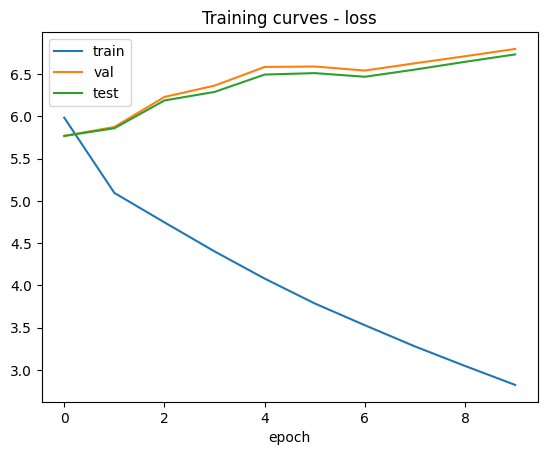

In [20]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])